In [1]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

In [3]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph
from langchain_teddynote.tools.tavily import TavilySearch

In [4]:
from langchain.schema import HumanMessage, AIMessage
from langchain_core.messages import ToolMessage

In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [6]:
llm = ChatOpenAI( 
    api_key=key, 
    model_name='gpt-4o-mini',
    temperature=0.1
)

In [7]:
tool = TavilySearch(max_results=1)      # 검색 도구 생성
tools = [tool]                          # 도구 목록에 넣기  

In [8]:
# LLM 에 도구 바인딩
llm_with_tools = llm.bind_tools(tools)

In [9]:
def chatbot(state: State):
    answer = llm_with_tools.invoke(state['messages'])

    print('==' * 50)
    print(f'chatbot() 실행\n')
    print(f"[1] 파라미터로 넘어온 state[messages]: \n{state['messages']}\n")
    # print(f'[2] chatbot answer: \n', answer , "\n")
    print(f'[2] LLM 실행 chatbot answer: \n', answer.content)
    print(f'[3] answer.additional_kwargs: \n', answer.additional_kwargs)
    print('==' * 50)

    return {'messages': [answer]}

In [10]:
graph_builder = StateGraph(State)

In [11]:
graph_builder.add_node('chatbot', chatbot)

In [ ]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """Run tools requested in the last AIMessage node"""

    def __init__(self, tools: list) -> None:
        self.tools_list = {tool.name: tool for tool in tools}
        print(f'======================================================')
        print('[BasicToolNode]')
        print('도구 호출 생성자')
        print(f'tools_list: {self.tools_list}')
        print(f'======================================================')
    
    def __call__(self, inputs: dict):
        if messages := inputs.get('messages', []):
            message = messages[-1]
        else:
            raise ValueError('No message found in input')
        
        print(f'======================================================')
        print('[BasicToolNode] call')
        print('도구 호출로 갔을 때')
        print('message.tool_calls:', message.tool_calls)
        print(f'======================================================')

        outputs = []

        for tool_call in message.tool_calls:    # message의 tool_calls 속성이 있는것은 도구 호출을 필요한 메시지가 있는 경우
            
            print(f'tool_call: {tool_call}')

            tool_result = self.tools_list[tool_call['name']].invoke(tool_call['args'])
            print(f'tool_result: {tool_result}')                                            

            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result, ensure_ascii=False), 
                    name=tool_call['name'], 
                    tool_call_id=tool_call['id']
                )
            )
            
        return {'messages': outputs}   

In [14]:
# 도구 노드 생성
tool_node = BasicToolNode(tools=[tool])

[BasicToolNode]
도구 호출 생성자
tools_list: {'tavily_web_search': TavilySearch(client=<tavily.tavily.TavilyClient object at 0x00000278D17E0290>, max_results=1)}


In [15]:
# 그래프에 도구 노드 추가
graph_builder.add_node('tools', tool_node) 

In [ ]:
from langgraph.graph import START, END

def route_tools(state: State):
    if messages := state.get('messages', []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    

    print('========================================================================')
    print('라우터에서 실행결과')
    print('route_tool content:', ai_message.content)
    print('route_tool:', ai_message.additional_kwargs)
    print('========================================================================\n\n')

    if hasattr(ai_message, 'tool_calls') and len(ai_message.tool_calls) > 0:
        print(f'라우터 리턴: {tools}')
        return 'tools'
    

    print(f'라우터 리턴: {END}')
    
    return END

In [18]:
graph_builder.add_conditional_edges(
    source='chatbot', 
    path=route_tools, 
    path_map={'tools': 'tools', END: END}
)

In [20]:
graph_builder.add_edge('tools', 'chatbot')

In [21]:
graph_builder.add_edge(START, 'chatbot')

In [22]:
graph = graph_builder.compile()

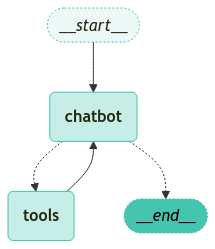

In [23]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [24]:
inputs = {"messages": "대한민국 수도에 대해서 검색해줘"}

for event in graph.stream(input=inputs, stream_mode='values'):
    print('==' * 50)
    print('[event]')

    for k, value in event.items():
        print(f'노드 이름: {k}')
        print()
        print(f"assistant 답변: ")
        print(f"{value}")

[event]
노드 이름: messages

assistant 답변: 
[HumanMessage(content='대한민국 수도에 대해서 검색해줘', additional_kwargs={}, response_metadata={}, id='748a62c1-ddbb-4c92-a74c-94e6f7426238')]
chatbot() 실행

[1] 파라미터로 넘어온 state[messages]: 
[HumanMessage(content='대한민국 수도에 대해서 검색해줘', additional_kwargs={}, response_metadata={}, id='748a62c1-ddbb-4c92-a74c-94e6f7426238')]

[2] LLM 실행 chatbot answer: 
 
[3] answer.additional_kwargs: 
 {'tool_calls': [{'id': 'call_00PkQRUkNN98hrGG45b7lTDs', 'function': {'arguments': '{"query":"대한민국 수도"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}
라우터에서 실행결과
route_tool content: 
route_tool: {'tool_calls': [{'id': 'call_00PkQRUkNN98hrGG45b7lTDs', 'function': {'arguments': '{"query":"대한민국 수도"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}


라우터 리턴: [TavilySearch(client=<tavily.tavily.TavilyClient object at 0x00000278D17E0290>, max_results=1)]
[event]
노드 이름: messages

assistant 답변: 
[HumanMessage(content='대한민국 수도에 대해서 검색해줘', addition

In [30]:
inputs = {"messages": "대한민국 수도에 대해서 검색해줘"}

i = 1

for event in graph.stream(input=inputs, stream_mode='values'):
    print('==' * 50)
    print(f'({i}) [event]')

    for key, value in event.items():
        print(f'[노드 이름]: {key}')            # key는 해당 노도의 이름
        print(f'[value]: {value}')                # value에는 해당 노드의 값

        if isinstance(value[-1], HumanMessage):
            print('==================== HumanMessage ========================')
            print(f"[해당 노드 값] value : \n{value[-1]}")
            print()
            # print(f"[해당 노드 값] value[-1].content HumanMessage - 답변: ")
            # print(f"{value['messages'][-1].content}")
            print('==================== END HumanMessage ====================')
            print() 
        elif isinstance(value[-1], AIMessage):
            print('==================== AIMessage ========================')
            print(f"[해당 노드 값] value : \n{value[-1]}")
            print()
            # print(f"[해당 노드 값] value[-1].content - assistant 답변: ")
            # print(f"{value['messages'][-1].content}")
            print('==================== END AIMessage ====================')     
            print()  
        elif isinstance(value[-1], ToolMessage):
            print('==================== ToolMessage ========================')
            print(f"[해당 노드 값] value : \n{value[-1]}")
            print('==================== END ToolMessage ====================')     
            print()

    i=i+1

    print('==' * 50)

(1) [event]
[노드 이름]: messages
[value]: [HumanMessage(content='대한민국 수도에 대해서 검색해줘', additional_kwargs={}, response_metadata={}, id='ce3cbbd1-e41d-4d10-8859-918260d88c30')]
==================== HumanMessage ========================
[해당 노드 값] value : 
content='대한민국 수도에 대해서 검색해줘' additional_kwargs={} response_metadata={} id='ce3cbbd1-e41d-4d10-8859-918260d88c30'

==================== END HumanMessage ====================

chatbot() 실행

[1] 파라미터로 넘어온 state[messages]: 
[HumanMessage(content='대한민국 수도에 대해서 검색해줘', additional_kwargs={}, response_metadata={}, id='ce3cbbd1-e41d-4d10-8859-918260d88c30')]

[2] LLM 실행 chatbot answer: 
 
[3] answer.additional_kwargs: 
 {'tool_calls': [{'id': 'call_7kqOtBTgoLlQ2M6WwOPoMr4u', 'function': {'arguments': '{"query":"대한민국 수도"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}
라우터에서 실행결과
route_tool content: 
route_tool: {'tool_calls': [{'id': 'call_7kqOtBTgoLlQ2M6WwOPoMr4u', 'function': {'arguments': '{"query":"대한민국 수도"}', 'name': 'tavily_

In [31]:
inputs = {"messages": "대한민국 수도에 대해서 검색해줘"}

for event in graph.stream(input=inputs, stream_mode='values'):
    print('==' * 50)
    print('[event]')

    for k, value in event.items():
        print(f'노드 이름: {k}')
        print()
        print(f'==========\nSTEP: {k} \n==========\n')
        print(f"{value[-1]}")

[event]
노드 이름: messages

STEP: messages 

content='대한민국 수도에 대해서 검색해줘' additional_kwargs={} response_metadata={} id='cabb322a-c061-4543-a209-05284f57ee10'
chatbot() 실행

[1] 파라미터로 넘어온 state[messages]: 
[HumanMessage(content='대한민국 수도에 대해서 검색해줘', additional_kwargs={}, response_metadata={}, id='cabb322a-c061-4543-a209-05284f57ee10')]

[2] LLM 실행 chatbot answer: 
 
[3] answer.additional_kwargs: 
 {'tool_calls': [{'id': 'call_ypCi8jR61UVDenBGyKJWDmz9', 'function': {'arguments': '{"query":"대한민국 수도"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}
라우터에서 실행결과
route_tool content: 
route_tool: {'tool_calls': [{'id': 'call_ypCi8jR61UVDenBGyKJWDmz9', 'function': {'arguments': '{"query":"대한민국 수도"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}


라우터 리턴: [TavilySearch(client=<tavily.tavily.TavilyClient object at 0x00000278D17E0290>, max_results=1)]
[event]
노드 이름: messages

STEP: messages 

content='' additional_kwargs={'tool_calls': [{'id': 'call_ypCi8jR6

In [32]:
from langchain_teddynote.messages import display_message_tree

inputs = {"messages": "대한민국 수도에 대해서 검색해줘"}

for event in graph.stream(input=inputs, stream_mode='values'):
    for key, value in event.items():
        print(f'==========\nSTEP: {key} \n==========\n')
        display_message_tree(value[-1])

STEP: messages 

    content: "대한민국 수도에 대해서 검색해줘"
    additional_kwargs: {}
    response_metadata: {}
    type: "human"
    name: None
    id: "252024a0-faeb-4280-82ac-d024922f5fa8"
    example: False
chatbot() 실행

[1] 파라미터로 넘어온 state[messages]: 
[HumanMessage(content='대한민국 수도에 대해서 검색해줘', additional_kwargs={}, response_metadata={}, id='252024a0-faeb-4280-82ac-d024922f5fa8')]

[2] LLM 실행 chatbot answer: 
 
[3] answer.additional_kwargs: 
 {'tool_calls': [{'id': 'call_tPzuQUlRCwui3FmTSSKDbhXv', 'function': {'arguments': '{"query":"대한민국 수도"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}
라우터에서 실행결과
route_tool content: 
route_tool: {'tool_calls': [{'id': 'call_tPzuQUlRCwui3FmTSSKDbhXv', 'function': {'arguments': '{"query":"대한민국 수도"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}


라우터 리턴: [TavilySearch(client=<tavily.tavily.TavilyClient object at 0x00000278D17E0290>, max_results=1)]
STEP: messages 

    content: ""
    additional_kwargs:
     